In [1]:
import sys
sys.path.append('../../30_data_tools/')

In [2]:
import json
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from pathlib import Path
from datetime import datetime

In [3]:
import subprocess
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse, peak_signal_noise_ratio as psnr

In [4]:
from pattern_creation import get_pattern_style, get_pattern_img_by_style
from apply_pattern import apply_pattern

In [5]:
from helper import load_dotenv

In [6]:
from enum import Enum

In [7]:
dotenv = load_dotenv()

In [8]:
with open('./config.json') as config_file:
    config = json.load(config_file)

In [9]:
df = pd.concat([pd.read_pickle(pkl) for pkl in dotenv['GENERIC_INFORMATION_DATA_DIR'].glob('./*.pkl')]).reset_index().drop(columns=['index'])
df.loc[
    :,
    'out_filename'
] = df.apply( lambda row: row.basic_name.replace('$PLACEHOLDER$', row.method), axis=1 )

In [10]:
neutral_gray = (np.ones((2500,2500)) * 128).astype('uint8')
center = (1250,1250)

In [11]:
def get_out_path( filepath ):
    original_file_name = filepath.name
    i = 1
    filepath = filepath.parent / original_file_name.replace('.x.', f'.{i}.')

    while filepath.exists():
        i += 1
        filepath = filepath.parent / original_file_name.replace('.x.', f'.{i}.')

    return filepath

In [12]:
def generate_screen( halftone_path, black_path ):
    res = subprocess.run(
        f'osascript ./generate_screen.sctp "{ halftone_path }" "{ black_path }"',
        shell=True,
        capture_output=True
    )

In [13]:
class MOIRE_TYPE(Enum):
    NO_MOIRE=1
    MOIRE_IN_TILE=2
    MOIRE_IN_SCREEN=3

In [14]:
0 / 0

ZeroDivisionError: division by zero

In [ ]:
real_tiles_data_file = Path('./11_pattern_images/real_tiles/real_tiles.pkl')

In [ ]:
real_tiles = pd.read_pickle( real_tiles_data_file )

In [ ]:
sample = df.sample(n=25)
new_rows = pd.DataFrame.from_dict([get_pattern_style(config) for i in tqdm(range(sample.shape[0]))])
new_rows.index = sample.index
new_rows = pd.merge(
    sample.loc[
        :,
        [c for c in sample.columns if c not in new_rows.columns]
    ],
    new_rows,
    left_index=True,
    right_index=True
)

In [ ]:
real_tiles = new_rows

In [ ]:
for i in tqdm(range(real_tiles.shape[0])):
    row = real_tiles.iloc[i]
    pattern_img = get_pattern_img_by_style(row, config)    
    img = Image.open(row.img_path).crop((
        row.bbox[0],
        row.bbox[1],
        row.bbox[0] + row.bbox[2],
        row.bbox[1] + row.bbox[3]
    ))
    center = (
        int(round(img.size[0] / 2)),
        int(round(img.size[1] / 2))
    )
    np_img = np.array(img)
    layers_mean = [np_img[:,:,i][(np_img[:,:,i] > 5) & (np_img[:,:,i] < 250)].sum() for i in range(np_img.shape[2])]
    active_layer = layers_mean.index(max(layers_mean))
    
    applied_pattern, _, ssim_value = apply_pattern(
        np_img[:,:,active_layer],
        pattern_img,
        center,
        config,
        method='soft_light',
        overlay_weight=1,
        log=lambda val: None
    )

    if 'tile_out_path' not in row or pd.isna(row.tile_out_path):
        tile_out_path = get_out_path( Path(f'./11_pattern_images/real_tiles/{ row.out_filename }.x.tile.jpg') )
    else:
        tile_out_path = row.tile_out_path

    if 'pattern_out_path' not in row or pd.isna(row.pattern_out_path):
        pattern_out_path = get_out_path( Path(f'./11_pattern_images/real_tiles/{ row.out_filename }.x.pattern.jpg') )
    else:
        pattern_out_path = row.pattern_out_path

    if 'screen_out_path' not in row or pd.isna(row.screen_out_path):
        screen_out_path = tile_out_path.parent / tile_out_path.name.replace('.tile.','.screen.')
    else:
        screen_out_path = row.screen_out_path

    if 'cmyk_out_path' not in row or pd.isna(row.cmyk_out_path):
        cmyk_out_path = tile_out_path.parent / tile_out_path.name.replace('.tile.','.4c.')
    else:
        cmyk_out_path = row.cmyk_out_path
    
    tile_img = Image.fromarray(applied_pattern)
    ImageOps.invert(tile_img).save(tile_out_path, dpi=(300,300))
    pattern_img.save(pattern_out_path, dpi=(300,300))
    generate_screen( tile_out_path.resolve(), screen_out_path.resolve() )
    screen_image = Image.open(screen_out_path)

    cmyk_out = np.array(img)
    cmyk_out[:,:,active_layer] = np.array(ImageOps.invert(screen_image))
    cmyk_out = Image.fromarray(cmyk_out, mode="CMYK")
    cmyk_out.save( cmyk_out_path )

    ssim_value = ssim(
        np.array(tile_img),
        np.array(screen_image)
    )

    real_tiles.loc[
        row.name,
        ['tile_out_path','pattern_out_path','screen_out_path', 'cmyk_out_path', 'active_layer', 'ssim']
    ] = (tile_out_path, pattern_out_path, screen_out_path, cmyk_out_path, active_layer, ssim_value)

In [ ]:
ssim(np.array(Image.open(sample.iloc[0].tile_out_path)), np.array(Image.open(sample.iloc[0].screen_out_path)))

In [ ]:
moires = {
    "508890.HBZP_1_M_278.p1.soft_light.1.1.tile" : MOIRE_TYPE.NO_MOIRE,
    "615297.tg39_p1000_U02_800-500.00OPT-932SA.48DE_SUT.p1.soft_light.2.1.tile" : MOIRE_TYPE.NO_MOIRE,
    "616466.tg45_000_INM0323_DE_MEN_KERN_TAUSCH_kor1.p22.soft_light.1.1.tile" : MOIRE_TYPE.NO_MOIRE,
    "508980.0107_O086.p1.soft_light.2.2.tile" : MOIRE_TYPE.NO_MOIRE,
    "606023.tg39_0079_20-1257_Part07_03_PGUE_GS_Premium_0321_DE.p1.soft_light.2.4.tile" : MOIRE_TYPE.NO_MOIRE,
    "606023.tg39_0047_20-1257_Part06_02_PGUE_GS_Premium_0321_DE.p1.soft_light.1.1.tile" : MOIRE_TYPE.MOIRE_IN_TILE,
    "613476.tg46_konv_693102_Top_03_BK_FS23_Suffix17_004_005_4C_Stuber.p2.soft_light.1.2.tile" : MOIRE_TYPE.NO_MOIRE,
    "616466.tg45_000_INM0323_DE_MEN_KERN_TAUSCH_kor1.p17.soft_light.1.2.tile" : MOIRE_TYPE.NO_MOIRE,
    "613781.tg39_Katalog AT 2023_24_print_Innen 56.p1.soft_light.2.3.tile" : MOIRE_TYPE.NO_MOIRE,
    "149128.tg52_230105_TM_Soul_Food_innen 208.p1.soft_light.1.1.tile" : MOIRE_TYPE.NO_MOIRE,
    "613233.tg46_UP_016_001_MRZ23_UPSUBHMRZ_SU_AS001_DE_DE_002.p1.soft_light.1.1.tile" : MOIRE_TYPE.NO_MOIRE,
    
}

In [ ]:
real_tiles.to_pickle(real_tiles_data_file)

In [ ]:
real_tiles.iloc[0].tile_out_path

# künstliche Daten generieren

In [ ]:
data_file = Path('./11_pattern_images/generated/generated.pkl')

if data_file.exists():
    data = pd.read_pickle(data_file)
else:
    rows = [get_pattern_style(config) for i in range(30)]
    data = pd.DataFrame.from_dict(rows)

for c in ['tile_out','pattern_out','screen_out']:
    if c not in data.columns:
        data.loc[
            :,
            c
        ] = np.nan

In [31]:
available_patterns = [pt.name.strip(pt.suffix) for pt in Path('../../22_andere_daten/patterns/').glob('./*.tif')]

row = {
    'use_blow_up_centered': False,
    'use_blow_up_region': False,
    'use_contract_centered': False,
    'use_contract_region': False,
    'use_pillow_disortion': False,
    'use_roll': False,
    'use_rotation': True,
    'use_scale': False,
    'use_stretch': False,
    'use_trapezoidal_distortion': False,
    'use_uniform_trapezoidal_distortion': False,
    'use_wave_deform': False,
    'pattern': '',
    'rotation_degree': 46,
    'creation_date' : None,
    'tile_out' : None,
    'pattern_out': None,
    'screen_out' : None,
    'ssim' : None
}

rows = []

for pt in available_patterns:
    next_row = row.copy()
    next_row['pattern'] = pt
    next_row['tile_out'] = f'{pt}.tile.jpg'
    next_row['pattern_out'] = f'{pt}.pattern.jpg'
    next_row['screen_out'] = f'{pt}.screen.jpg'

    
    rows.append(
        next_row
    )
    

In [ ]:
rows = [get_pattern_style(config) for i in range(10)]

data = pd.concat([data, pd.DataFrame.from_dict(rows)]).reset_index().drop(columns=['index'])

In [ ]:
sample = data.iloc[-10:]

In [ ]:
sample = data.loc[
    pd.isna(data.ssim)
]

In [ ]:
row

In [ ]:
sample = data.loc[
    data.tile_out.str.contains('tile.23.')
]

In [32]:
data = pd.DataFrame.from_dict(rows)
sample = data.sample(frac=1)

In [33]:
for i in tqdm(range(sample.shape[0])):
    row = sample.iloc[i]
    pattern_img = get_pattern_img_by_style(row, config)    

    applied_pattern, _, ssim_value = apply_pattern(
        neutral_gray,
        pattern_img,
        center,
        config,
        method='soft_light',
        overlay_weight=1,
        log=lambda val: None
    )

    if pd.isna(row.tile_out):
        tile_out_path = get_out_path( Path(f'./11_pattern_images/generated/tile.x.jpg') )
    else:
        tile_out_path = Path(f'./11_pattern_images/generated/{ row.tile_out }')

    if pd.isna(row.pattern_out):
        pattern_out_path = get_out_path( Path(f'./11_pattern_images/generated/pattern.x.jpg') )
    else:
        pattern_out_path = Path(f'./11_pattern_images/generated/{ row.pattern_out }')

    if pd.isna(row.screen_out):
        screen_out_path = get_out_path( Path(f'./11_pattern_images/generated/screen.x.jpg') )
    else:
        screen_out_path = Path(f'./11_pattern_images/generated/{ row.screen_out }')
    
    tile_img = Image.fromarray(applied_pattern)    
    tile_img.save(tile_out_path, dpi=(300,300))
    pattern_img.save(pattern_out_path, dpi=(300,300))
    generate_screen( tile_out_path.resolve(), screen_out_path.resolve() )

    ssim_value = ssim(
        np.array(tile_img.resize((1000,1000))),
        np.array(Image.open(screen_out_path).resize((1000,1000)))
    )

    data.loc[
        row.name,
        ['creation_date','tile_out','pattern_out','screen_out', 'ssim']
    ] = (datetime.now(), tile_out_path.name, pattern_out_path.name, screen_out_path.name, ssim_value)

  0%|                                                  | 0/21 [00:03<?, ?it/s]


TypeError: 'numpy.float64' object is not callable

In [20]:
pattern_img = get_pattern_img_by_style(data.iloc[0], config)

In [ ]:
pattern_img.size

In [ ]:
gray_img = Image.fromarray( (np.ones((1696,1696)) * 125).astype('uint8') )

In [75]:
for cov in range(30, 250, 20):
    other_gray = (np.ones((2500,2500)) * cov).astype('uint8')
    
    new_tile, pattern_mask, ssim = apply_pattern(
        other_gray,
        pattern_img,
        center,
        config,
        method='soft_light',
        overlay_weight=1,
        log=lambda val: None
    )

    Image.fromarray(new_tile).save(f'./test_{ cov }.jpg', dpi=(300, 300))

In [65]:
from apply_pattern import change_brightness, equal_tile_size

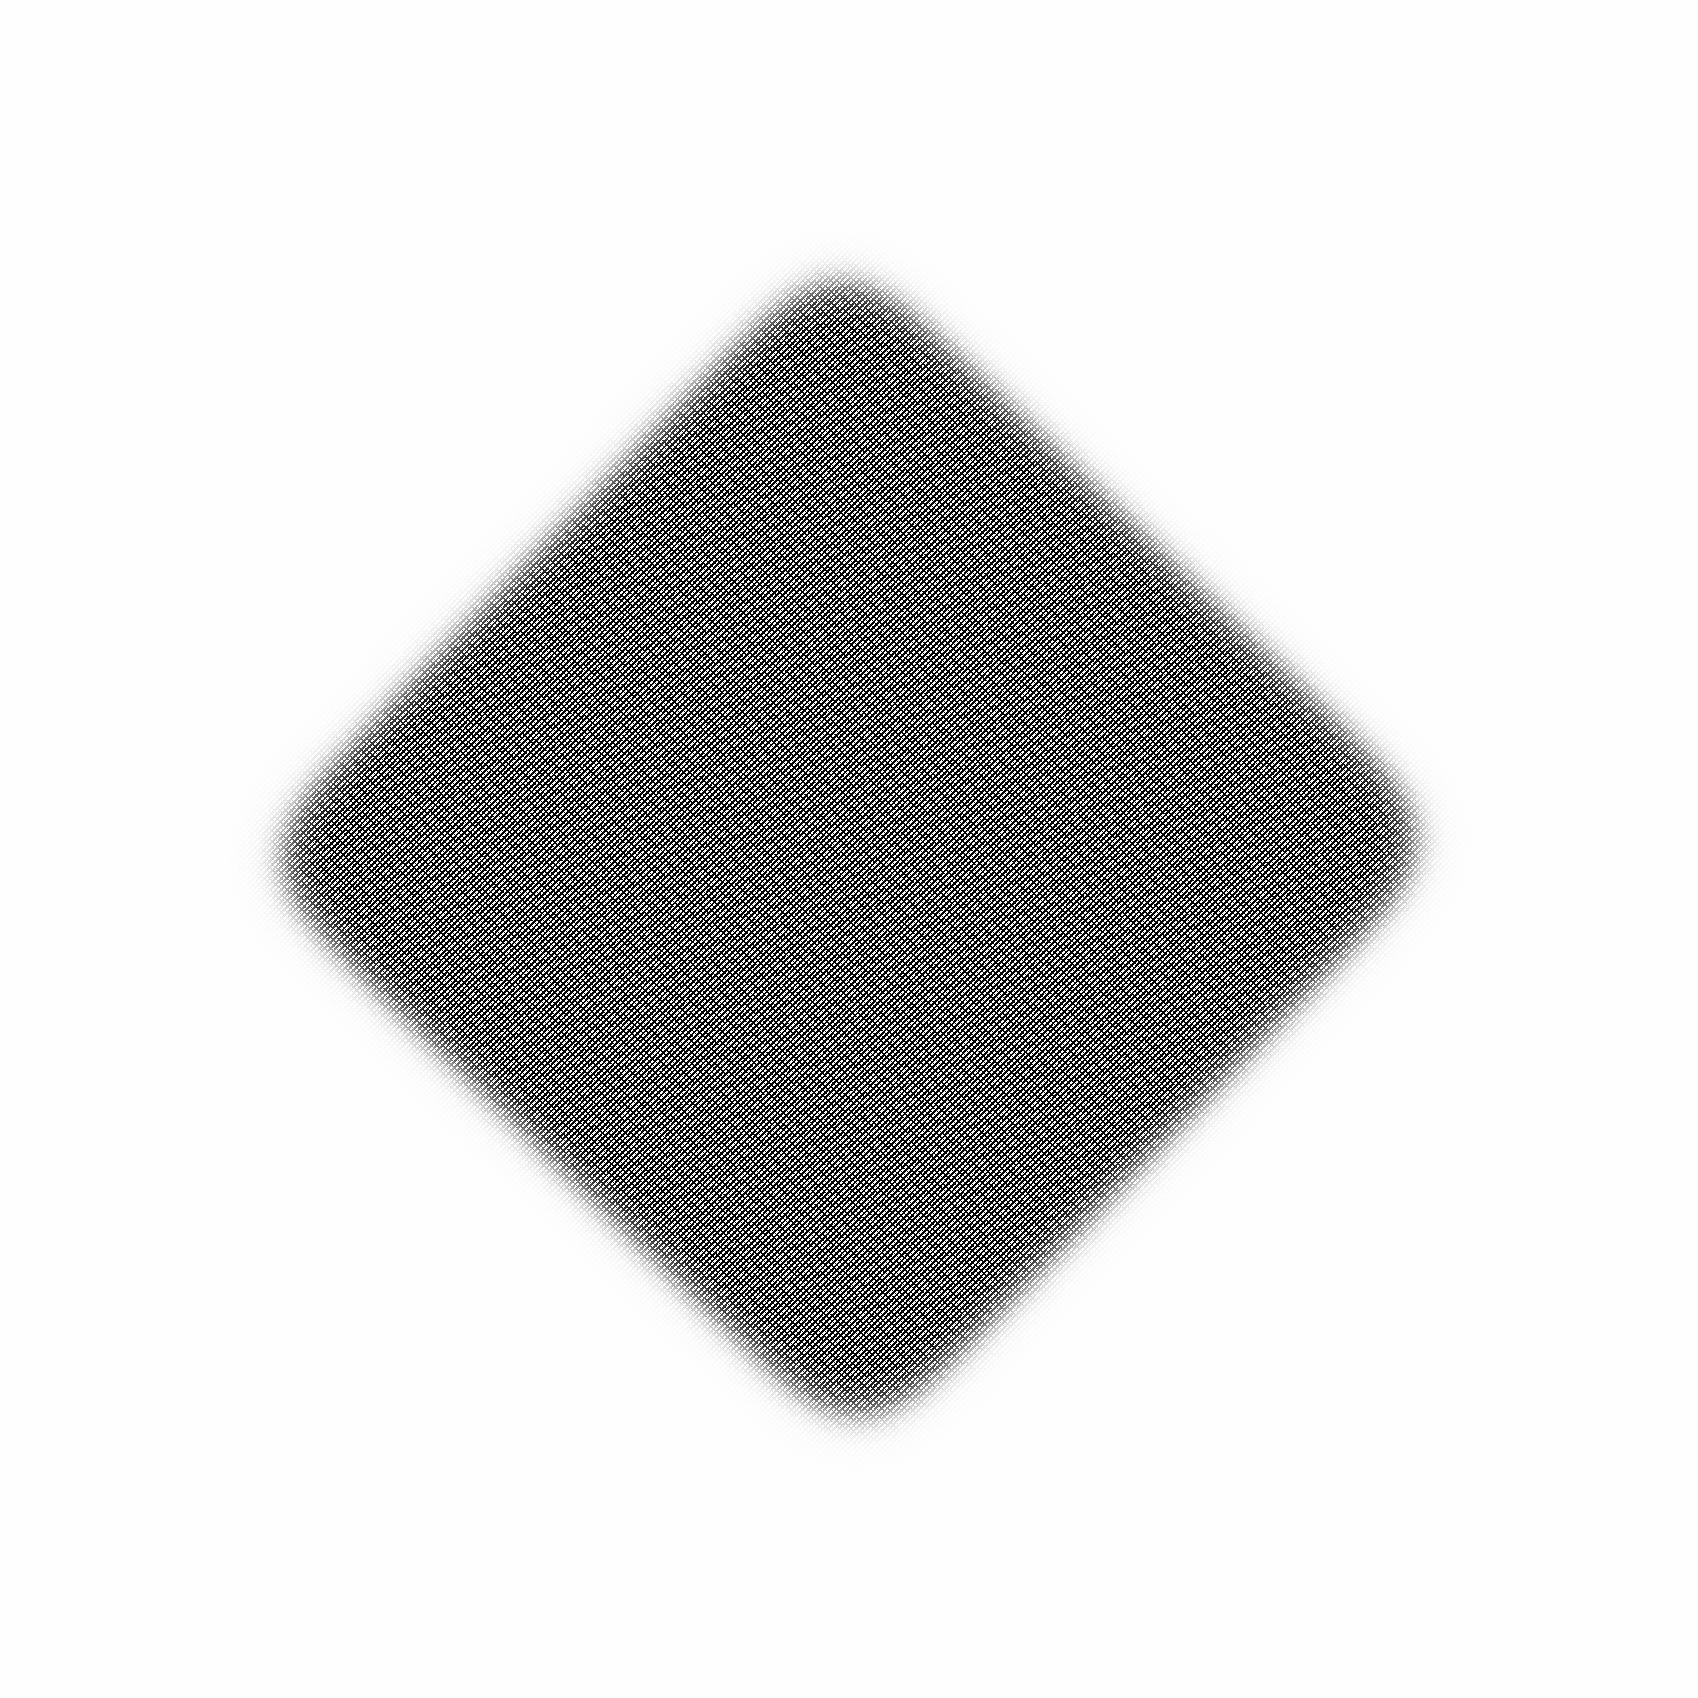

In [94]:
Image.fromarray((equalized * 255).astype('uint8'))

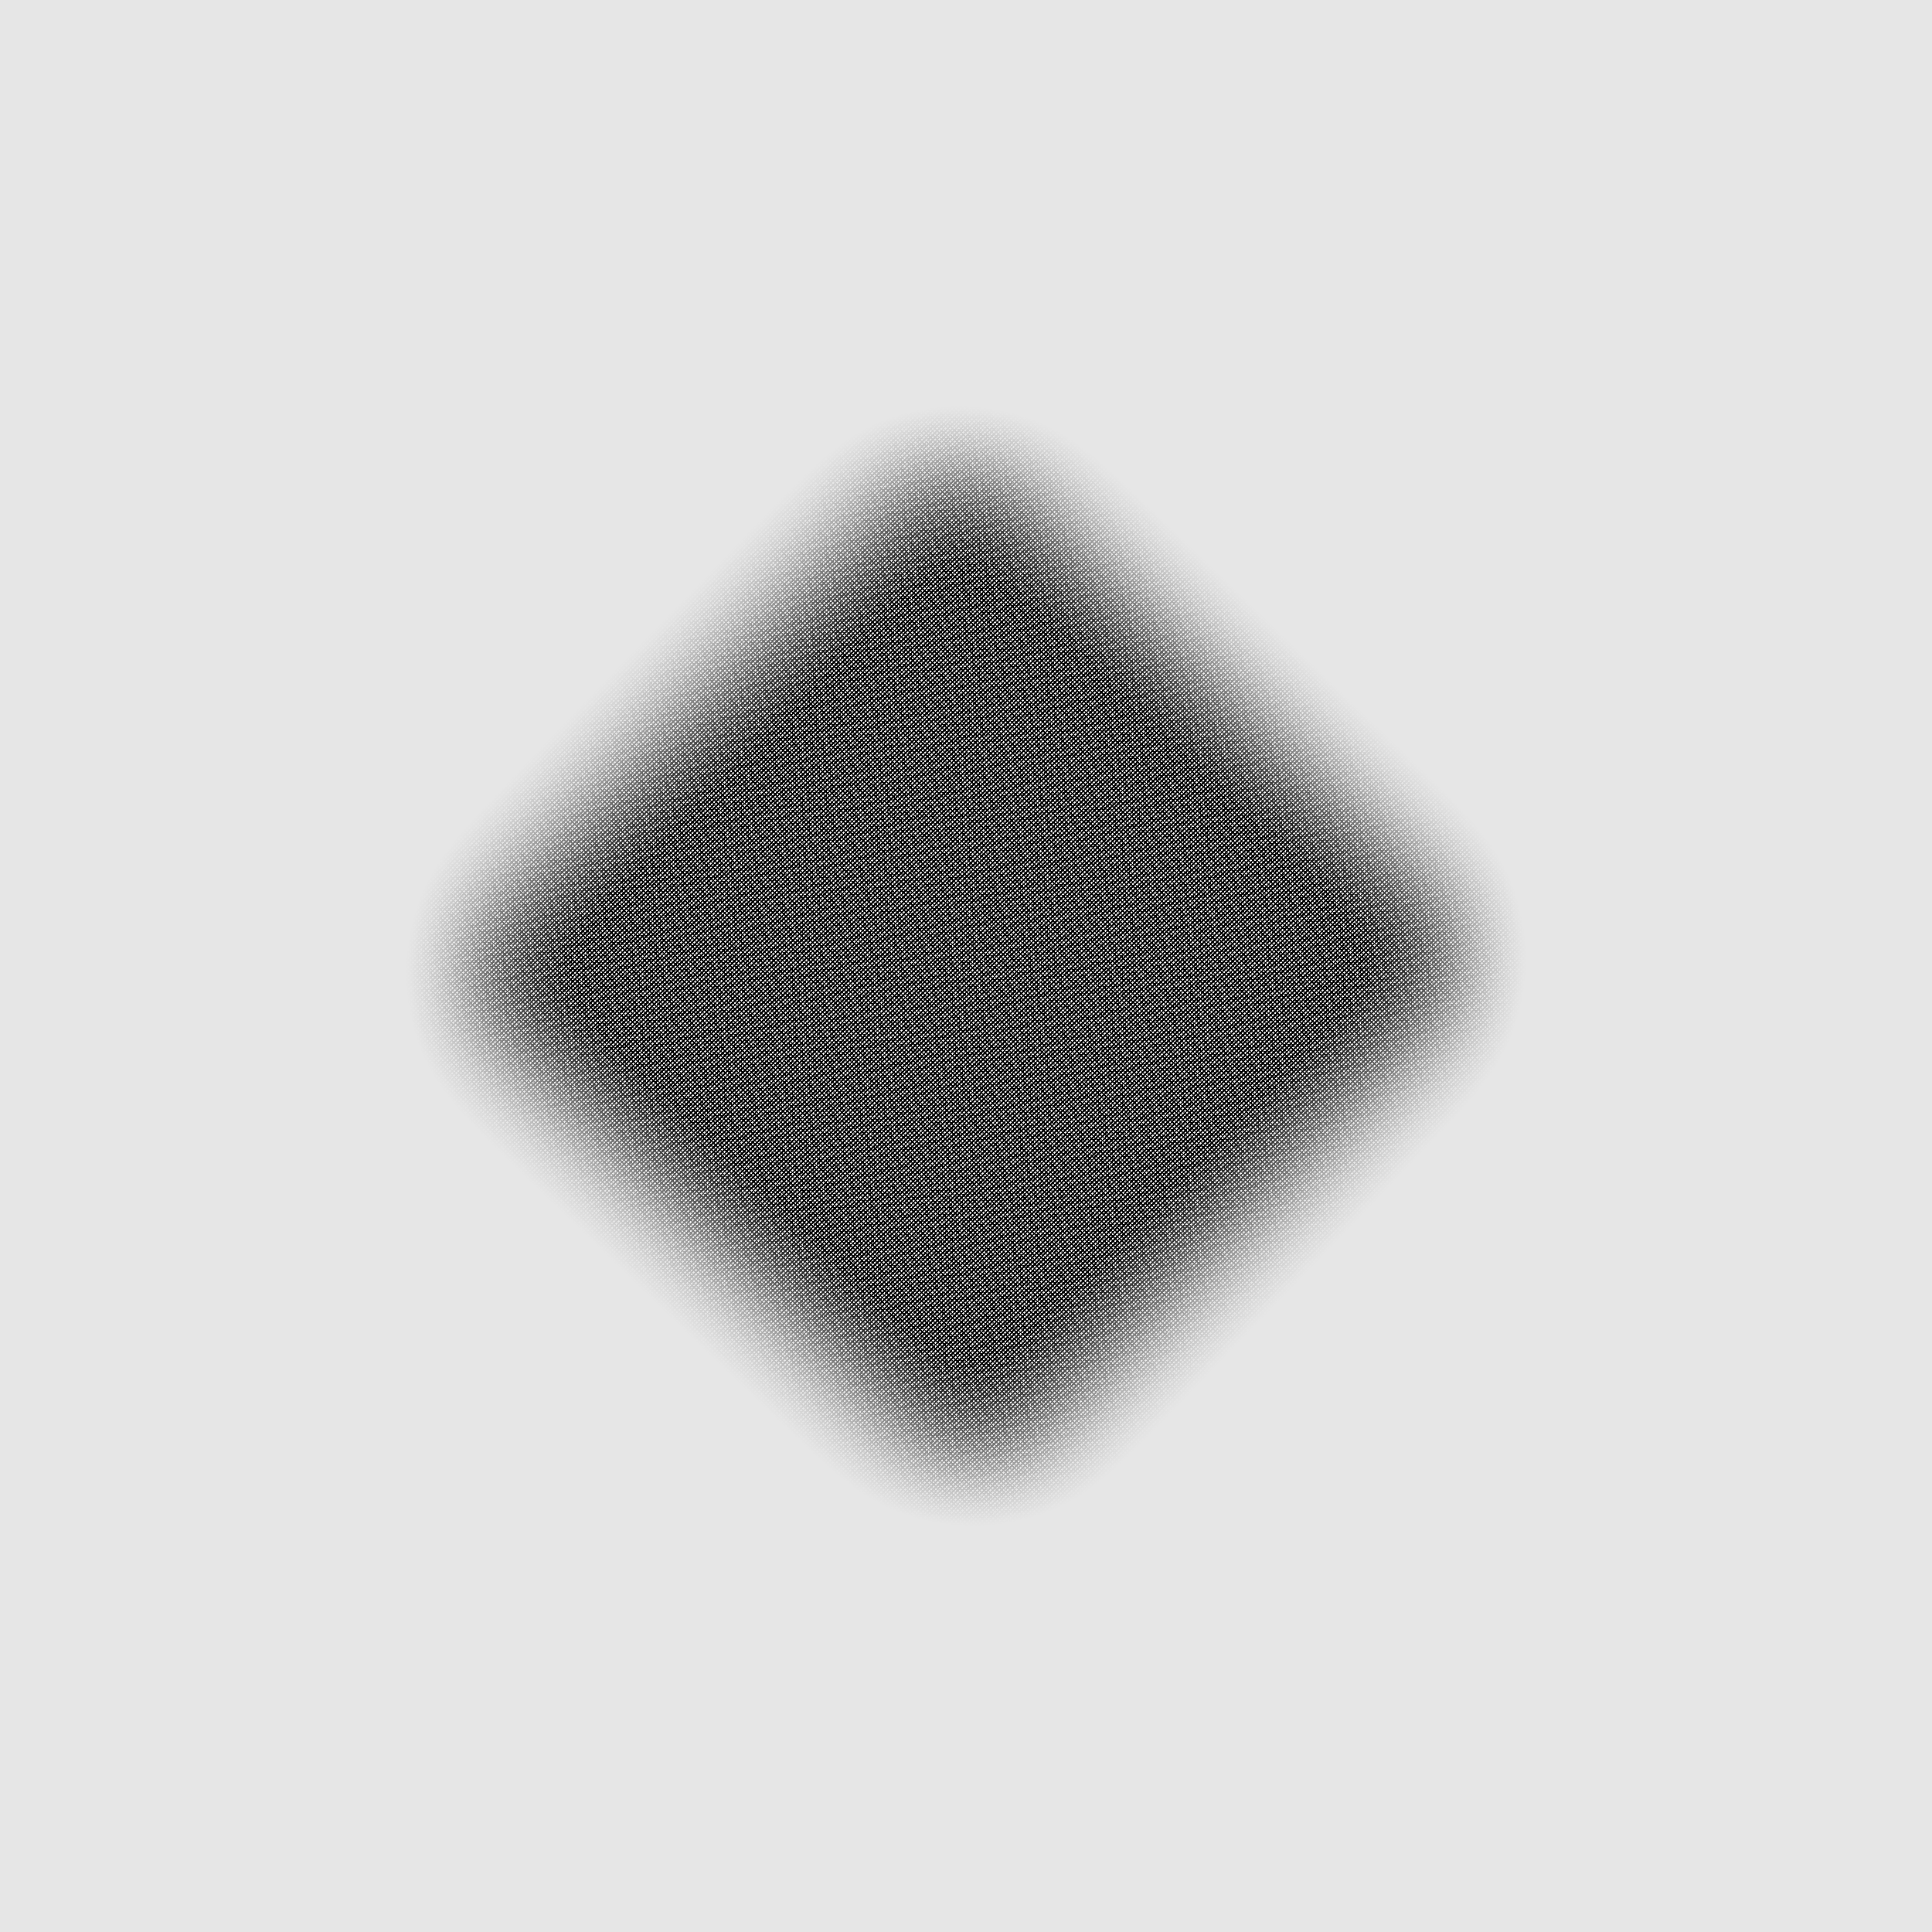

In [92]:
Image.fromarray(new_tile)

In [79]:
pattern_mask.shape

(1698, 1698)

In [86]:
2500-1698

802

In [91]:
equalized = equal_brightness(
    new_tile[401:401+1698,401:401+1698] / 255,
    np.array(other_gray[:1698,:1698]) / 255,
    mask=Image.fromarray((pattern_mask * 255).astype('uint8'))
)

0.5347720848327537 diff one
more diff 0.5347720848327537
more diff 0.5037130323131233
more diff 0.48572620432375274
more diff 0.46969314365406084
more diff 0.45535331256083744
more diff 0.4427078737914477
more diff 0.431770516617376
more diff 0.42248712631915686
more diff 0.41471321874185735
more diff 0.4082336630743228
more diff 0.40281500271890375
more diff 0.3982379512494445
more diff 0.3943199174510831
more diff 0.39091418641494524
more diff 0.3879092266945513


In [90]:
def equal_brightness( source, target, difference_threshold=0.01, mask=None ):   
    out = source.copy()
    if mask:
        np_mask = equal_tile_size( target, np.array(mask) / 255 )    

    def get_diff():
        if mask:
            return abs((((out * np_mask).sum()+1) / (np_mask.sum()+1)) - (((target * np_mask).sum()+1) / (np_mask.sum()+1)))

        return abs(out.mean() - target.mean())
         
    diff = get_diff()
    i = 0
    print(diff, 'diff one')
    while diff > difference_threshold and i < 15:  
        print( "more diff", diff )
        if out.max() != 0:
            strength = ((out.mean() - target.mean()) / out.mean()) * -1
            out = change_brightness( out, strength )
            out = (out - out.min())

            if out.max() != 0:
                out = out / out.max()
            
            diff = get_diff()

        i += 1

    
    out[out < 0] = 0
    out[out > 1] = 1
    return out

In [ ]:
config['pattern_mask']

In [ ]:
Image.fromarray(
    (np.array(get_pattern_mask(
        np.array(pattern_img),
        config['pattern_mask']['thumb_sizes'],
        config['pattern_mask']['mask_decrease_factor'],
        config['pattern_mask']['mask_decrease_factor'],
        config['pattern_mask']['mask_decrease_factor'],
        config['pattern_mask']['increase_contrast_factor']
    )) * 255).astype('uint8')
)

In [ ]:
Image.fromarray( out.astype('uint8') )

In [ ]:
Image.fromarray(np.array(gray_img) * _).convert('L')

In [ ]:
Image.fromarray(applied_pattern)

In [ ]:
from PIL import ImageChops

In [ ]:
ImageChops.soft_light(gray_img, pattern_img)

In [ ]:
pattern_img

In [ ]:
data.loc[
    :,
    ['pattern','ssim']
].sort_values('ssim')

In [ ]:
from enum import Enum

In [ ]:
data.loc[
    :,
    ["pattern"] + [c for c in data.columns if 'use_' in c]
].shape

In [ ]:
data.loc[
    :,
    ["pattern"] + [c for c in data.columns if 'use_' in c]
].drop_duplicates().shape

In [ ]:
moires = {
    "tile.1" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.2" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.3" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.4" : MOIRE_TYPE.NO_MOIRE,
    "tile.5" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.6" : MOIRE_TYPE.MOIRE_IN_SCREEN, # querstreifen
    "tile.7" : MOIRE_TYPE.MOIRE_IN_SCREEN, # querstreifen
    "tile.8" : MOIRE_TYPE.MOIRE_IN_SCREEN, # querstreifen
    "tile.9" : MOIRE_TYPE.MOIRE_IN_SCREEN, # querstreifen
    "tile.10" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.11" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.12" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.13" : MOIRE_TYPE.MOIRE_IN_SCREEN, # querstreifen
    "tile.14" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.15" : MOIRE_TYPE.MOIRE_IN_SCREEN, #black
    "tile.16" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.17" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.18" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.19" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.20" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.21" : MOIRE_TYPE.NO_MOIRE,
    "tile.22" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.23" : MOIRE_TYPE.MOIRE_IN_SCREEN, #black
    "tile.24" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.25" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.26" : MOIRE_TYPE.NO_MOIRE,
    "tile.27" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.28" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.29" : MOIRE_TYPE.MOIRE_IN_SCREEN,  #black    
    "tile.30" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.31" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.32" : MOIRE_TYPE.NO_MOIRE,
    "tile.33" : MOIRE_TYPE.NO_MOIRE,  #black
    "tile.34" : MOIRE_TYPE.NO_MOIRE,
    "tile.35" : MOIRE_TYPE.NO_MOIRE,  #black
    "tile.36" : MOIRE_TYPE.MOIRE_IN_TILE,
    "tile.37" : MOIRE_TYPE.NO_MOIRE,
    "tile.38" : MOIRE_TYPE.MOIRE_IN_SCREEN,
    "tile.39" : MOIRE_TYPE.NO_MOIRE,
    "tile.40" : MOIRE_TYPE.MOIRE_IN_TILE
}

## Learnings

- die Pattern lines_150lpi_1 und lines_150lpi_2 sind nicht gut mit blow_up_centered und contract_centered kombinierbar

In [ ]:
data.loc[
    data.tile_out.isin(["tile.6.jpg","tile.7.jpg","tile.8.jpg","tile.9.jpg","tile.13.jpg"])
].T

In [ ]:
for key in moires:
    data.loc[
        (pd.isna(data.tile_out) == False) &
        (data.tile_out.str.contains(key + '.jpg')),
        'has_moire'
    ] = moires[key].value

In [ ]:
data.loc[(pd.isna(data.has_moire) == False)].shape

In [ ]:
data.loc[data.has_moire == 1].shape

In [ ]:
indexes = data.loc[(pd.isna(data.has_moire) == False)].index

for idx in tqdm(indexes):
    tile = Image.open(Path('./11_pattern_images/generated/') / data.loc[idx,'tile_out'])
    screen = Image.open(Path('./11_pattern_images/generated/') / data.loc[idx,'screen_out'])

    if "mse" not in data.columns or pd.isna(data.loc[idx].mse):
        data.loc[
            idx,
            'mse'
        ] = mse(
            np.array(tile),
            np.array(screen)
        )
    
    if "psnr" not in data.columns or pd.isna(data.loc[idx].psnr):
        data.loc[
            idx,
            'psnr'
        ] = psnr(
            np.array(tile),
            np.array(screen)
        )

In [ ]:
data.loc[data.has_moire == 1].shape[0], data.shape[0]

In [ ]:
corr_frame = data.loc[
    pd.isna(data.has_moire) == False,
    ['has_moire','ssim','mse','psnr']
]
corr_frame.has_moire = corr_frame.has_moire.astype('int')

corr_frame.corr("spearman")

In [ ]:
data.loc[
    :,
    ['pattern','has_moire','ssim']
].groupby(['pattern','has_moire']).count().unstack('has_moire').fillna(0)

In [ ]:
data[pd.isna(data.creation_date) == False].shape

In [ ]:
data.loc[
    pd.isna(data.use_blow_up_region),
    'use_blow_up_region'
] = False

data.loc[
    pd.isna(data.use_contract_region),
    'use_contract_region'
] = False

data.loc[
    pd.isna(data.use_wave_deform),
    'use_wave_deform'
] = False

In [ ]:
data.to_pickle(data_file)